In [1]:
# Meta-Analysis of Sedation and Extubation Outcomes
# Random-effects meta-analysis using DerSimonian-Laird method

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from pathlib import Path
import glob
from datetime import datetime

# Change to project root directory
os.chdir('..')
print(f"Working directory: {os.getcwd()}")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


Working directory: /Users/wliao0504/.cursor/worktrees/CLIF-epi-of-sedation/xYjxu


In [2]:
# Configuration
BOX_ROOT = Path("/Users/wliao0504/Library/CloudStorage/Box-Box/CLIF/projects/CLIF-epi-of-sedation")
OUTPUT_DIR = Path("output/pooled")
CURRENT_TIME_STR = datetime.now().strftime('%Y%m%d_%H%M%S')

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Variables of interest
SEDATION_VARS = ['propofol_diff', 'fentanyl_eq_diff', 'midazolam_eq_diff']

print(f"BOX_ROOT: {BOX_ROOT}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")
print(f"Timestamp: {CURRENT_TIME_STR}")


BOX_ROOT: /Users/wliao0504/Library/CloudStorage/Box-Box/CLIF/projects/CLIF-epi-of-sedation
OUTPUT_DIR: output/pooled
Timestamp: 20251104_224930


In [3]:
# Utility Functions for Random-Effects Meta-Analysis (DerSimonian-Laird)

def random_effects_meta_analysis(effects, variances, study_names=None):
    """
    Perform random-effects meta-analysis using DerSimonian-Laird method.
    
    Parameters:
    -----------
    effects : array-like
        Effect estimates (e.g., log odds ratios) from each study
    variances : array-like
        Variances of the effect estimates
    study_names : list, optional
        Names of the studies
        
    Returns:
    --------
    dict with keys:
        - pooled_effect: Pooled effect estimate
        - pooled_se: Standard error of pooled effect
        - pooled_ci_lower: Lower 95% CI
        - pooled_ci_upper: Upper 95% CI
        - tau2: Between-study variance
        - Q: Q-statistic for heterogeneity
        - Q_pval: P-value for Q-statistic
        - I2: I-squared statistic (percentage)
        - studies: DataFrame with individual study results
    """
    effects = np.array(effects)
    variances = np.array(variances)
    n_studies = len(effects)
    
    if study_names is None:
        study_names = [f"Study {i+1}" for i in range(n_studies)]
    
    # Calculate weights for fixed-effect model
    weights_fe = 1 / variances
    
    # Calculate Q-statistic
    pooled_effect_fe = np.sum(weights_fe * effects) / np.sum(weights_fe)
    Q = np.sum(weights_fe * (effects - pooled_effect_fe)**2)
    df = n_studies - 1
    Q_pval = 1 - stats.chi2.cdf(Q, df) if df > 0 else np.nan
    
    # Calculate tau-squared (between-study variance) using DerSimonian-Laird
    C = np.sum(weights_fe) - np.sum(weights_fe**2) / np.sum(weights_fe)
    tau2 = max(0, (Q - df) / C) if C > 0 else 0
    
    # Calculate I-squared
    I2 = max(0, (Q - df) / Q * 100) if Q > 0 else 0
    
    # Calculate random-effects weights
    weights_re = 1 / (variances + tau2)
    
    # Calculate pooled effect and SE
    pooled_effect = np.sum(weights_re * effects) / np.sum(weights_re)
    pooled_var = 1 / np.sum(weights_re)
    pooled_se = np.sqrt(pooled_var)
    
    # Calculate 95% CI
    pooled_ci_lower = pooled_effect - 1.96 * pooled_se
    pooled_ci_upper = pooled_effect + 1.96 * pooled_se
    
    # Create study results DataFrame
    studies_df = pd.DataFrame({
        'study': study_names,
        'effect': effects,
        'se': np.sqrt(variances),
        'variance': variances,
        'weight': weights_re / np.sum(weights_re) * 100  # as percentage
    })
    
    return {
        'pooled_effect': pooled_effect,
        'pooled_se': pooled_se,
        'pooled_ci_lower': pooled_ci_lower,
        'pooled_ci_upper': pooled_ci_upper,
        'tau2': tau2,
        'Q': Q,
        'Q_pval': Q_pval,
        'I2': I2,
        'studies': studies_df
    }


def create_forest_plot(meta_results, variable_name, output_path=None):
    """
    Create a forest plot for meta-analysis results.
    
    Parameters:
    -----------
    meta_results : dict
        Results from random_effects_meta_analysis()
    variable_name : str
        Name of the variable being analyzed
    output_path : str or Path, optional
        Path to save the figure
    """
    studies_df = meta_results['studies']
    
    # Convert log OR to OR for plotting
    studies_df['or'] = np.exp(studies_df['effect'])
    studies_df['or_ci_lower'] = np.exp(studies_df['effect'] - 1.96 * studies_df['se'])
    studies_df['or_ci_upper'] = np.exp(studies_df['effect'] + 1.96 * studies_df['se'])
    
    pooled_or = np.exp(meta_results['pooled_effect'])
    pooled_or_lower = np.exp(meta_results['pooled_ci_lower'])
    pooled_or_upper = np.exp(meta_results['pooled_ci_upper'])
    
    n_studies = len(studies_df)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, max(6, n_studies * 0.5 + 2)))
    
    # Plot individual studies
    y_positions = range(n_studies, 0, -1)
    for i, (idx, row) in enumerate(studies_df.iterrows()):
        y = y_positions[i]
        
        # Plot CI line
        ax.plot([row['or_ci_lower'], row['or_ci_upper']], [y, y], 
                'k-', linewidth=1.5, zorder=1)
        
        # Plot point estimate (square sized by weight)
        size = row['weight'] * 10  # Scale for visibility
        ax.scatter(row['or'], y, s=size, marker='s', 
                  color='steelblue', edgecolors='black', linewidths=1, zorder=2)
    
    # Plot pooled estimate (diamond)
    pooled_y = 0
    diamond_height = 0.3
    diamond_x = [pooled_or_lower, pooled_or, pooled_or_upper, pooled_or]
    diamond_y = [pooled_y, pooled_y + diamond_height, pooled_y, pooled_y - diamond_height]
    ax.fill(diamond_x, diamond_y, color='darkred', alpha=0.7, edgecolor='black', linewidth=2, zorder=3)
    
    # Add vertical line at OR = 1
    ax.axvline(x=1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # Set y-axis labels
    y_labels = list(studies_df['study']) + ['Pooled']
    ax.set_yticks(list(y_positions) + [pooled_y])
    ax.set_yticklabels(y_labels)
    
    # Set x-axis to log scale
    ax.set_xscale('log')
    ax.set_xlabel('Odds Ratio (95% CI)', fontsize=12, fontweight='bold')
    
    # Title with heterogeneity statistics
    title = f'Forest Plot: {variable_name}\n'
    title += f'I² = {meta_results["I2"]:.1f}%, τ² = {meta_results["tau2"]:.4f}, '
    title += f'Q = {meta_results["Q"]:.2f} (p = {meta_results["Q_pval"]:.3f})'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Add grid
    ax.grid(True, axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Forest plot saved to: {output_path}")
    
    return fig, ax

print("Meta-analysis utility functions loaded successfully.")


Meta-analysis utility functions loaded successfully.


# 1. Data Loading and Preparation


In [4]:
# Auto-discover site-specific logit summary files
def find_latest_logit_files(box_root):
    """
    Find the most recent logit_summary and logit_covmat files for each site.
    
    Parameters:
    -----------
    box_root : Path
        Root directory for Box files
        
    Returns:
    --------
    dict : Dictionary mapping site names to file paths
    """
    pattern = str(box_root / "*/final/*_logit_summary_*.csv")
    summary_files = glob.glob(pattern)
    
    if not summary_files:
        print(f"Warning: No logit_summary files found matching pattern: {pattern}")
        return {}
    
    # Group files by site
    site_files = {}
    for filepath in summary_files:
        path_obj = Path(filepath)
        site_name = path_obj.parts[-3]  # Get site name from directory structure
        
        # Extract timestamp from filename
        filename = path_obj.name
        # Pattern: {site}_logit_summary_{timestamp}.csv
        parts = filename.replace('.csv', '').split('_')
        if len(parts) >= 4:
            timestamp = parts[-1]  # Last part is timestamp
            
            if site_name not in site_files:
                site_files[site_name] = []
            site_files[site_name].append((timestamp, filepath))
    
    # Get the most recent file for each site
    latest_files = {}
    for site_name, files in site_files.items():
        # Sort by timestamp (descending) and get the most recent
        files.sort(reverse=True, key=lambda x: x[0])
        latest_files[site_name] = files[0][1]
    
    return latest_files

# Find all available site files
site_files = find_latest_logit_files(BOX_ROOT)

print(f"\nFound {len(site_files)} site(s) with logit results:")
for site, filepath in site_files.items():
    print(f"  - {site}: {Path(filepath).name}")
    
if not site_files:
    raise ValueError("No site files found. Please check the BOX_ROOT path and file patterns.")



Found 4 site(s) with logit results:
  - UCMC: ucmc_logit_summary_20251104_164214.csv
  - MIMIC: mimic_logit_summary_20251104_164105.csv
  - NW: nu_logit_summary_20251104_171900.csv
  - Emory: emory_logit_summary_20251104_183253.csv


In [5]:
# Load data from all sites and extract sedation variable coefficients
def load_site_results(file_path, site_name, variables_of_interest):
    """
    Load logit summary results for a specific site.
    
    Parameters:
    -----------
    file_path : str
        Path to the logit_summary CSV file
    site_name : str
        Name of the site
    variables_of_interest : list
        List of variable names to extract
        
    Returns:
    --------
    DataFrame with columns: site, variable, coef, se, pval
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # The summary table typically has columns like:
    # Column 0: variable name, Column 1: coef, Column 2: std err, Column 3: z, Column 4: P>|z|, Column 5-6: CI
    # But column names may vary, so we'll be flexible
    
    # Try to identify the correct columns
    col_names = df.columns.tolist()
    
    # Common column name patterns
    if len(col_names) >= 3:
        var_col = col_names[0]  # First column is usually the variable name
        coef_col = col_names[1]  # Second column is usually coefficient
        se_col = col_names[2]    # Third column is usually standard error
        
        # Look for p-value column
        pval_col = None
        for col in col_names:
            if 'P>' in col or 'p-value' in col.lower() or 'pval' in col.lower():
                pval_col = col
                break
        if pval_col is None and len(col_names) >= 5:
            pval_col = col_names[4]  # Often 5th column
    else:
        raise ValueError(f"Unexpected file format in {file_path}")
    
    # Filter for variables of interest
    results = []
    for var in variables_of_interest:
        var_data = df[df[var_col] == var]
        if len(var_data) > 0:
            row = var_data.iloc[0]
            results.append({
                'site': site_name,
                'variable': var,
                'coef': float(row[coef_col]),
                'se': float(row[se_col]),
                'pval': float(row[pval_col]) if pval_col else np.nan
            })
        else:
            print(f"Warning: Variable '{var}' not found in {site_name} results")
    
    return pd.DataFrame(results)

# Load all site results
all_site_data = []
for site_name, file_path in site_files.items():
    try:
        site_data = load_site_results(file_path, site_name, SEDATION_VARS)
        all_site_data.append(site_data)
        print(f"✓ Loaded {len(site_data)} variables from {site_name}")
    except Exception as e:
        print(f"✗ Error loading {site_name}: {str(e)}")

# Combine all site data
combined_data = pd.concat(all_site_data, ignore_index=True)

# Calculate variance from SE
combined_data['variance'] = combined_data['se'] ** 2

print(f"\n{len(combined_data)} total observations loaded")
print("\nData summary:")
print(combined_data.to_string(index=False))


✓ Loaded 3 variables from UCMC
✓ Loaded 3 variables from MIMIC
✓ Loaded 3 variables from NW
✓ Loaded 3 variables from Emory

12 total observations loaded

Data summary:
 site          variable      coef       se  pval     variance
 UCMC     propofol_diff -0.000100 0.000035 0.002 1.218010e-09
 UCMC  fentanyl_eq_diff -0.000100 0.000056 0.028 3.147210e-09
 UCMC midazolam_eq_diff -0.019500 0.005000 0.000 2.500000e-05
MIMIC     propofol_diff -0.000200 0.000024 0.000 5.856400e-10
MIMIC  fentanyl_eq_diff -0.000400 0.000045 0.000 2.034010e-09
MIMIC midazolam_eq_diff -0.015200 0.002000 0.000 4.000000e-06
   NW     propofol_diff -0.000100 0.000029 0.000 8.294400e-10
   NW  fentanyl_eq_diff -0.000200 0.000051 0.000 2.601000e-09
   NW midazolam_eq_diff -0.010900 0.002000 0.000 4.000000e-06
Emory     propofol_diff  0.000008 0.000051 0.872 2.621440e-09
Emory  fentanyl_eq_diff -0.000084 0.000043 0.052 1.857610e-09
Emory midazolam_eq_diff -0.011800 0.003000 0.000 9.000000e-06


# 2. Perform Random-Effects Meta-Analysis


In [6]:
# Perform meta-analysis for each sedation variable
meta_results = {}

for var in SEDATION_VARS:
    print(f"\n{'='*70}")
    print(f"Meta-Analysis for: {var}")
    print(f"{'='*70}")
    
    # Filter data for this variable
    var_data = combined_data[combined_data['variable'] == var].copy()
    
    if len(var_data) < 2:
        print(f"Warning: Less than 2 sites have data for {var}. Skipping meta-analysis.")
        continue
    
    # Extract effects and variances
    effects = var_data['coef'].values
    variances = var_data['variance'].values
    study_names = var_data['site'].values
    
    # Perform random-effects meta-analysis
    results = random_effects_meta_analysis(effects, variances, study_names)
    
    # Store results
    meta_results[var] = results
    
    # Display results
    print(f"\nIndividual Study Results:")
    print(results['studies'].to_string(index=False))
    
    print(f"\n{'─'*70}")
    print(f"Pooled Results (Log Odds Ratio):")
    print(f"  Estimate: {results['pooled_effect']:.4f}")
    print(f"  Standard Error: {results['pooled_se']:.4f}")
    print(f"  95% CI: [{results['pooled_ci_lower']:.4f}, {results['pooled_ci_upper']:.4f}]")
    
    print(f"\nPooled Results (Odds Ratio):")
    pooled_or = np.exp(results['pooled_effect'])
    pooled_or_lower = np.exp(results['pooled_ci_lower'])
    pooled_or_upper = np.exp(results['pooled_ci_upper'])
    print(f"  Odds Ratio: {pooled_or:.4f}")
    print(f"  95% CI: [{pooled_or_lower:.4f}, {pooled_or_upper:.4f}]")
    
    print(f"\nHeterogeneity Statistics:")
    print(f"  Q-statistic: {results['Q']:.2f} (p = {results['Q_pval']:.4f})")
    print(f"  I²: {results['I2']:.1f}%")
    print(f"  τ² (tau-squared): {results['tau2']:.4f}")
    
    # Interpretation
    if results['Q_pval'] < 0.05:
        print(f"  → Significant heterogeneity detected (p < 0.05)")
    else:
        print(f"  → No significant heterogeneity detected (p ≥ 0.05)")
    
    if results['I2'] < 25:
        print(f"  → Low heterogeneity (I² < 25%)")
    elif results['I2'] < 50:
        print(f"  → Moderate heterogeneity (25% ≤ I² < 50%)")
    elif results['I2'] < 75:
        print(f"  → Substantial heterogeneity (50% ≤ I² < 75%)")
    else:
        print(f"  → Considerable heterogeneity (I² ≥ 75%)")

print(f"\n{'='*70}")
print(f"Meta-analysis completed for {len(meta_results)} variable(s)")
print(f"{'='*70}")



Meta-Analysis for: propofol_diff

Individual Study Results:
study    effect       se     variance    weight
 UCMC -0.000100 0.000035 1.218010e-09 25.029924
MIMIC -0.000200 0.000024 5.856400e-10 27.829026
   NW -0.000100 0.000029 8.294400e-10 26.678788
Emory  0.000008 0.000051 2.621440e-09 20.462262

──────────────────────────────────────────────────────────────────────
Pooled Results (Log Odds Ratio):
  Estimate: -0.0001
  Standard Error: 0.0000
  95% CI: [-0.0002, -0.0000]

Pooled Results (Odds Ratio):
  Odds Ratio: 0.9999
  95% CI: [0.9998, 1.0000]

Heterogeneity Statistics:
  Q-statistic: 17.47 (p = 0.0006)
  I²: 82.8%
  τ² (tau-squared): 0.0000
  → Significant heterogeneity detected (p < 0.05)
  → Considerable heterogeneity (I² ≥ 75%)

Meta-Analysis for: fentanyl_eq_diff

Individual Study Results:
study    effect       se     variance    weight
 UCMC -0.000100 0.000056 3.147210e-09 24.230891
MIMIC -0.000400 0.000045 2.034010e-09 25.393434
   NW -0.000200 0.000051 2.601000e-09 24.7

# 3. Create Forest Plots



Creating forest plot for propofol_diff...
Forest plot saved to: output/pooled/forest_plot_propofol_diff_20251104_224930.png


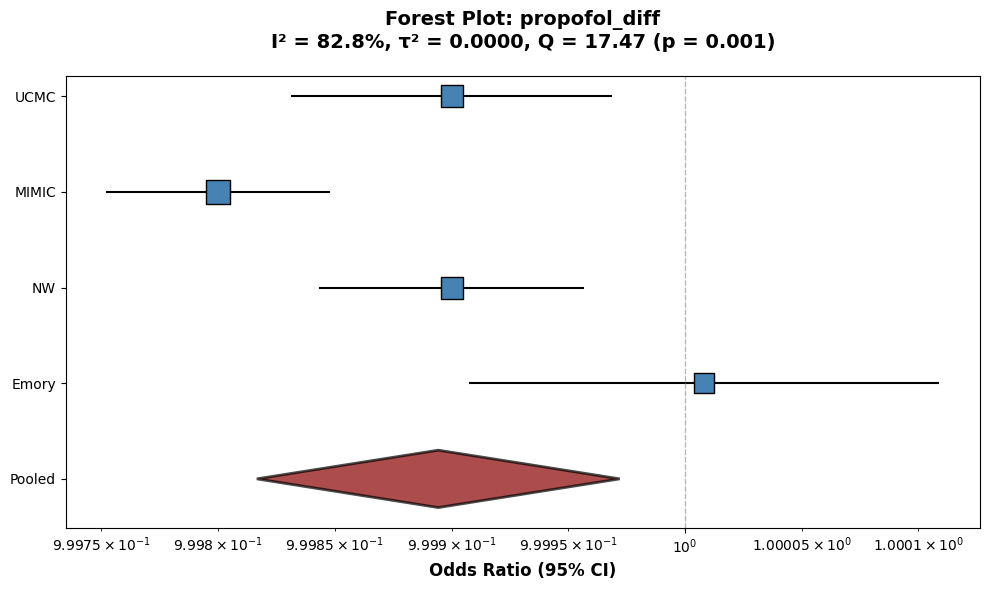


Creating forest plot for fentanyl_eq_diff...
Forest plot saved to: output/pooled/forest_plot_fentanyl_eq_diff_20251104_224930.png


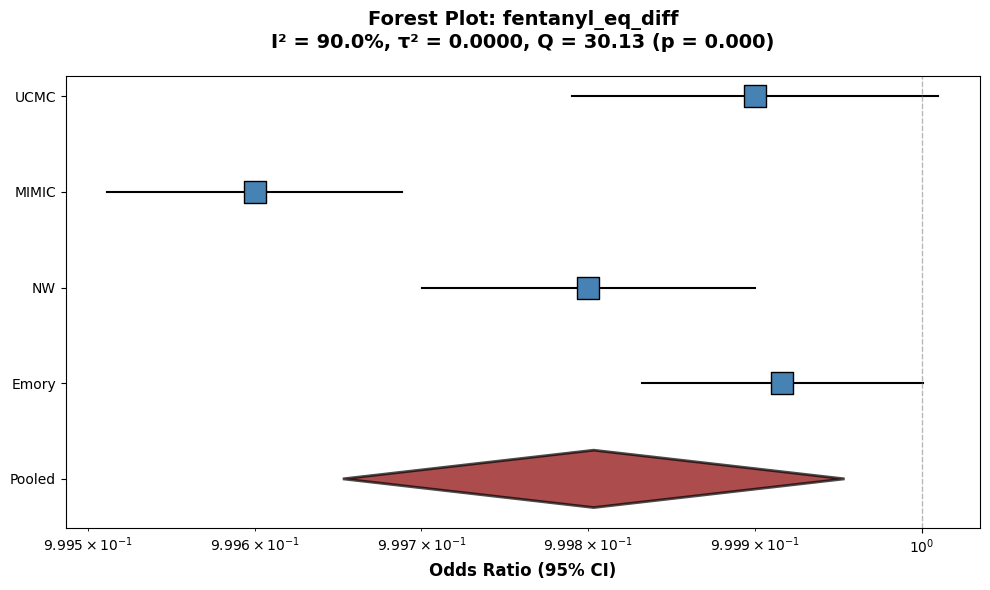


Creating forest plot for midazolam_eq_diff...
Forest plot saved to: output/pooled/forest_plot_midazolam_eq_diff_20251104_224930.png


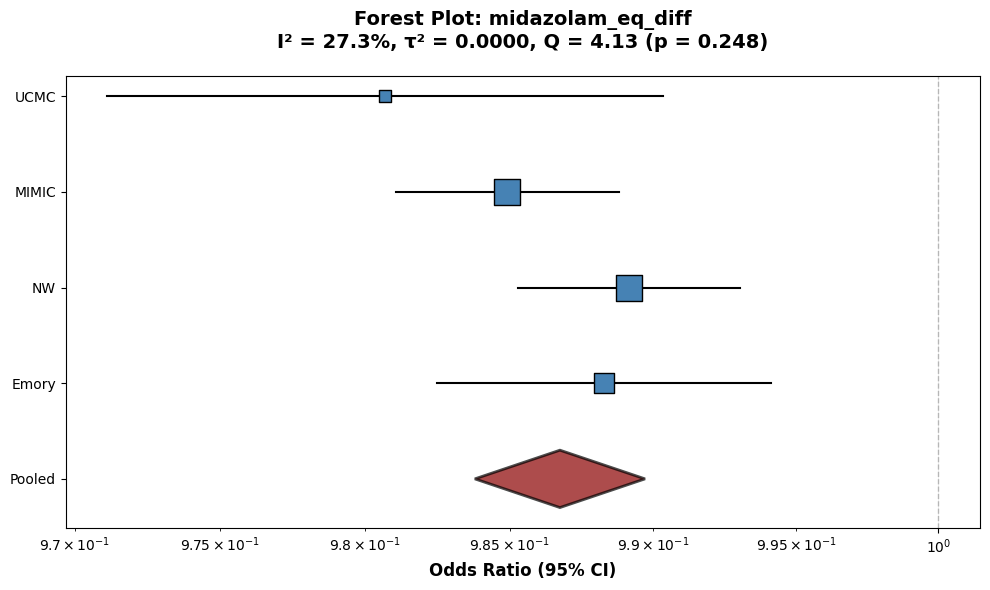


✓ Created 3 forest plot(s)


In [7]:
# Create forest plots for each variable
forest_plot_files = {}

for var, results in meta_results.items():
    print(f"\nCreating forest plot for {var}...")
    
    # Create output filename
    output_file = OUTPUT_DIR / f"forest_plot_{var}_{CURRENT_TIME_STR}.png"
    
    # Create forest plot
    fig, ax = create_forest_plot(results, var, output_path=output_file)
    
    # Store filename
    forest_plot_files[var] = output_file
    
    # Display the plot
    plt.show()
    plt.close()

print(f"\n✓ Created {len(forest_plot_files)} forest plot(s)")


# 4. Export Results


In [8]:
# Export pooled results summary
pooled_summary = []

for var, results in meta_results.items():
    pooled_summary.append({
        'variable': var,
        'log_or': results['pooled_effect'],
        'log_or_se': results['pooled_se'],
        'log_or_ci_lower': results['pooled_ci_lower'],
        'log_or_ci_upper': results['pooled_ci_upper'],
        'or': np.exp(results['pooled_effect']),
        'or_ci_lower': np.exp(results['pooled_ci_lower']),
        'or_ci_upper': np.exp(results['pooled_ci_upper']),
        'n_studies': len(results['studies']),
        'tau2': results['tau2'],
        'Q': results['Q'],
        'Q_pval': results['Q_pval'],
        'I2': results['I2']
    })

pooled_df = pd.DataFrame(pooled_summary)
pooled_output = OUTPUT_DIR / f"meta_analysis_pooled_results_{CURRENT_TIME_STR}.csv"
pooled_df.to_csv(pooled_output, index=False)
print(f"✓ Saved pooled results to: {pooled_output}")

# Display pooled results
print("\nPooled Results Summary:")
print(pooled_df.to_string(index=False))


✓ Saved pooled results to: output/pooled/meta_analysis_pooled_results_20251104_224930.csv

Pooled Results Summary:
         variable    log_or  log_or_se  log_or_ci_lower  log_or_ci_upper       or  or_ci_lower  or_ci_upper  n_studies         tau2         Q   Q_pval        I2
    propofol_diff -0.000106   0.000040        -0.000183        -0.000028 0.999894     0.999817     0.999972          4 5.069092e-09 17.471740 0.000565 82.829414
 fentanyl_eq_diff -0.000197   0.000077        -0.000347        -0.000046 0.999803     0.999653     0.999954          4 2.116843e-08 30.131848 0.000001 90.043757
midazolam_eq_diff -0.013345   0.001531        -0.016345        -0.010345 0.986744     0.983788     0.989708          4 2.575136e-06  4.127172 0.248055 27.310993


In [9]:
# Export heterogeneity statistics
heterogeneity_stats = []

for var, results in meta_results.items():
    heterogeneity_stats.append({
        'variable': var,
        'n_studies': len(results['studies']),
        'Q_statistic': results['Q'],
        'Q_pval': results['Q_pval'],
        'I2_percent': results['I2'],
        'tau2': results['tau2'],
        'heterogeneity_level': (
            'Low' if results['I2'] < 25 else
            'Moderate' if results['I2'] < 50 else
            'Substantial' if results['I2'] < 75 else
            'Considerable'
        )
    })

heterogeneity_df = pd.DataFrame(heterogeneity_stats)
heterogeneity_output = OUTPUT_DIR / f"heterogeneity_statistics_{CURRENT_TIME_STR}.csv"
heterogeneity_df.to_csv(heterogeneity_output, index=False)
print(f"\n✓ Saved heterogeneity statistics to: {heterogeneity_output}")

# Display heterogeneity statistics
print("\nHeterogeneity Statistics:")
print(heterogeneity_df.to_string(index=False))



✓ Saved heterogeneity statistics to: output/pooled/heterogeneity_statistics_20251104_224930.csv

Heterogeneity Statistics:
         variable  n_studies  Q_statistic   Q_pval  I2_percent         tau2 heterogeneity_level
    propofol_diff          4    17.471740 0.000565   82.829414 5.069092e-09        Considerable
 fentanyl_eq_diff          4    30.131848 0.000001   90.043757 2.116843e-08        Considerable
midazolam_eq_diff          4     4.127172 0.248055   27.310993 2.575136e-06            Moderate


In [10]:
heterogeneity_output

PosixPath('output/pooled/heterogeneity_statistics_20251104_224930.csv')

In [11]:
# Final Summary
print("\n" + "="*70)
print("META-ANALYSIS COMPLETE")
print("="*70)

print(f"\nSites analyzed: {len(site_files)}")
for site in site_files.keys():
    print(f"  - {site}")

print(f"\nVariables analyzed: {len(meta_results)}")
for var in meta_results.keys():
    print(f"  - {var}")

print(f"\nOutput directory: {OUTPUT_DIR}")
print("\nGenerated files:")
print(f"  1. Pooled results: {pooled_output.name}")
print(f"  2. Heterogeneity statistics: {heterogeneity_output.name}")
for var, filepath in forest_plot_files.items():
    print(f"  3. Forest plot ({var}): {filepath.name}")

print("\n" + "="*70)
print("All results saved successfully!")
print("="*70)



META-ANALYSIS COMPLETE

Sites analyzed: 4
  - UCMC
  - MIMIC
  - NW
  - Emory

Variables analyzed: 3
  - propofol_diff
  - fentanyl_eq_diff
  - midazolam_eq_diff

Output directory: output/pooled

Generated files:
  1. Pooled results: meta_analysis_pooled_results_20251104_224930.csv
  2. Heterogeneity statistics: heterogeneity_statistics_20251104_224930.csv
  3. Forest plot (propofol_diff): forest_plot_propofol_diff_20251104_224930.png
  3. Forest plot (fentanyl_eq_diff): forest_plot_fentanyl_eq_diff_20251104_224930.png
  3. Forest plot (midazolam_eq_diff): forest_plot_midazolam_eq_diff_20251104_224930.png

All results saved successfully!


# Interpreting the Results

## Logistic Regression Coefficients
- **Coefficient (Log OR)**: The change in log odds for a one-unit increase in the predictor
- **Standard Error (SE)**: Uncertainty in the coefficient estimate
- **P-value**: Tests if the coefficient is significantly different from zero (α = 0.05)

## Odds Ratios (OR)
- **OR = exp(coefficient)**: Multiplicative change in odds
  - OR > 1: Increased odds of successful extubation
  - OR < 1: Decreased odds of successful extubation
  - OR = 1: No association
- **95% CI**: Range of plausible values for the true OR
  - If CI excludes 1, the association is statistically significant

## Random-Effects Meta-Analysis
Uses the **DerSimonian-Laird method** to:
1. Calculate pooled effect across sites
2. Account for between-site heterogeneity (τ²)
3. Provide more conservative confidence intervals than fixed-effect models

## Heterogeneity Statistics
- **Q-statistic**: Tests for heterogeneity (p < 0.05 indicates significant heterogeneity)
- **I²**: Percentage of variation due to heterogeneity rather than chance
  - 0-25%: Low heterogeneity
  - 25-50%: Moderate heterogeneity
  - 50-75%: Substantial heterogeneity
  - 75-100%: Considerable heterogeneity
- **τ² (tau-squared)**: Variance between studies (on log OR scale)

## Forest Plots
- **Squares**: Individual site estimates (size proportional to weight)
- **Horizontal lines**: 95% confidence intervals
- **Diamond**: Pooled estimate and 95% CI
- **Vertical dashed line**: Null effect (OR = 1)
